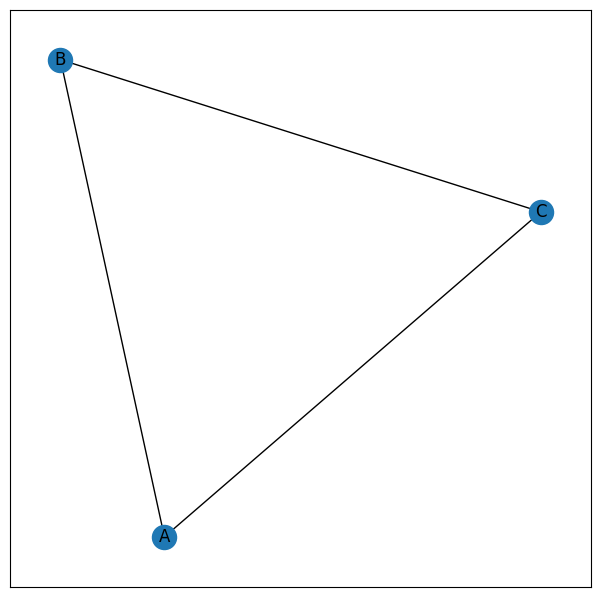

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_node('A')
G.add_nodes_from(['B', 'C'])

G.add_edge('A', 'B')
G.add_edges_from([('B', 'C'), ('A', 'C')])

plt.figure(figsize=(7.5, 7.5),)

nx.draw_networkx(G)